In [22]:
import pandas as pd 
from glob import glob
from tqdm import tqdm_notebook
from utils import *
%matplotlib inline

from tensorflow.python.client import device_lib
import subprocess

In [20]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17384236658103115204]

In [2]:
path="../data/"
df_list=[]

In [3]:
small_df = pd.read_csv("../data/small-set.csv")

In [28]:
rr = df_to_image_array_1d(small_df,96, preprocess_input=keras.applications.mobilenet_v2.preprocess_input)

In [29]:
img = rr[0]
img = np.tile(img, 3)
img.shape

(96, 96, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


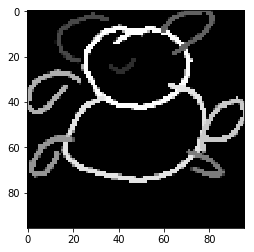

In [26]:
plt.imshow(img)

In [4]:
gen = image_generator_xd(96,12,2,preprocess_input=keras.applications.xception.preprocess_input)

In [5]:
gg = next(gen)

k:  0


In [13]:
img = gg[0][11]
# img = np.tile(img[:,:,0], 3)
img.shape

(96, 96, 3)

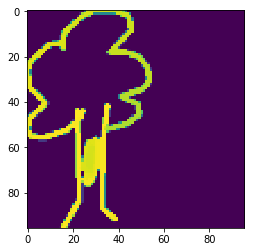

In [14]:
plt.imshow(img[:,:,2])

In [15]:
img[:,:,2].mean()

-0.80585

In [16]:
img[:,:,1].mean()

-0.79748946

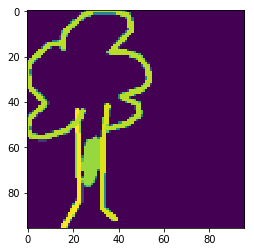

In [18]:
plt.imshow(img[:,:,0])

In [42]:
from models import *


In [47]:
def get_mnet_1d(imsize, alpha=1.4):
	mnet_raw = MobileNetV2(
		input_shape=(imsize, imsize, 3), alpha=alpha,
		pooling="max", classes=num_classes, weights="imagenet", include_top=False)

	model = get_model_with_imagenet_weights(mnet_raw, freeze=False)
	preprocess_input = keras.applications.mobilenet_v2.preprocess_input

	return model , preprocess_input

In [50]:
model = get_mnet_1d(224,alpha=1.)

9412608/9406464 [==============================] - 0s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________

In [44]:
model = get_mnet_1d(128,alpha=1.0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   288         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [300]:
df_all = pd.concat(df_list)

In [301]:
df_all.shape

(49707579, 3)

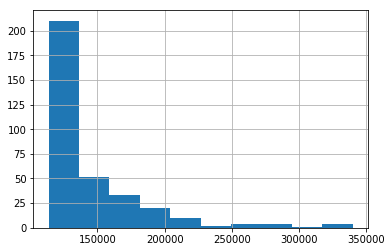

In [302]:
df_all.word.value_counts().hist()

In [18]:
# df_all.word.value_counts()

In [14]:
recognition_rate_df = df_all.groupby("word").aggregate({"recognized":"mean"})

In [17]:
recognition_rate_df.sort_values("recognized")

,recognized
word,
stove,0.811636
bat,0.814061
eraser,0.814431
string bean,0.815952
hot tub,0.817632
lion,0.818328
cow,0.821389
dresser,0.822238
elephant,0.826863


In [6]:
# df_all = df_all[df_all.recognized==True]

In [303]:
df_all.shape

(49707579, 3)

In [7]:
df_all.shape

(45512752, 3)

In [304]:
df_all = df_all.sample(frac=1,random_state=0).reset_index(drop=True)

In [305]:
classfiles = glob(path+"/train/*.csv")
nametoid = {v[:-4].split("/")[-1].replace(" ", "_") :i
               for i, v in enumerate(classfiles) if "df_all_raw" not in v} #adds underscores
idtoname = {i: v[:-4].split("/")[-1].replace(" ", "_")
               for i, v in enumerate(classfiles) if "df_all_raw" not in v} #adds underscores
# imsize = 32  
# batch_size=4

In [313]:
save_obj([nametoid,idtoname],"../data/nametoid_idtoname.pik")

In [306]:
df_all["target"] = df_all.word.apply(lambda x: nametoid[x.replace(" ", "_")])

In [314]:
df_all.drop(["recognized","word"],axis=1,inplace=True)

In [316]:
df_all.head()

,drawing,target
0,"[[[18, 23, 50, 62, 100, 94, 95], [254, 60, 14,...",56
1,"[[[107, 61, 43, 24, 20, 19, 27, 52, 84, 112, 1...",200
2,"[[[14, 25, 77, 126, 171, 255], [0, 6, 23, 31, ...",202
3,"[[[1, 1, 5, 11, 12, 14, 18, 117, 156, 244, 244...",326
4,"[[[36, 57, 80, 128, 175, 226], [0, 10, 16, 22,...",48


In [318]:
df_all.to_csv(path+"/df_all_nonrec.csv",index=False)

In [3]:
df_all = pd.read_csv(path+"/df_all_nonrec.csv")

### Train-test split

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

In [321]:
sss = StratifiedShuffleSplit(test_size=0.1, random_state=0)
folds10 = []
for train_index, test_index in tqdm_notebook(sss.split(df_all.drawing,df_all.target)):
    folds10.append({"train_index":train_index, "test_index":test_index})
    


In [322]:
save_obj(folds10, "../data/folds10_nonrec.pik")

In [4]:
folds10 = load_obj("../data/folds10_nonrec.pik")

In [5]:
folds10 = folds10[8]

In [6]:
train_index = folds10["train_index"]
valid_index = folds10["test_index"]

In [7]:
sample_index = train_index[:len(train_index)//4]
len(sample_index)

11184205

In [8]:
samplel_df_fold8= df_all.iloc[sample_index]

In [30]:
samplel_df_fold8.shape

(11184205, 2)

In [9]:
valid_df_fold8 = df_all.iloc[valid_index]

In [33]:
!ls ../data/

df_all_nonrec.csv   nametoid_idtoname.pik  train
df_all_raw.csv	    sample_submission.csv  train_test_split.pik
folds10_nonrec.pik  small-set.csv
folds10.pik	    test_simplified.csv


In [35]:
valid_df_fold8.to_csv("../data/valid_df_nonrec_fold8.csv",index=False)

In [10]:
samplel_df_fold8.to_csv("../data/sample_df_nonrec_fold8.csv",index=False)

In [ ]:
# df_all.iloc[valid_index].to_csv("../data/valid_fold0_10")

### Augmentation test

In [5]:
# strokes = small_df.drawing.iloc[0]

# %time results = json.loads(strokes)

In [4]:
# # im = Image.new('RGBA', (11,13), 'white')
# im = Image.new("P", (256,256), color=255)
# image_draw = ImageDraw.Draw(image)
# w, h = im.size
# draw = ImageDraw.Draw(im)
# draw.line((0, 0, 1, 1), fill='cyan')
# draw.line((0, h-10, 1, h-2), fill='magenta')
# draw.line((w-1, h-10, w-20, h-2), fill='yellow')
# draw.line((w-1, 0, w-20, 1), fill='black')


In [5]:
# desired_size = 368
# old_size = im.size
# ratio = float(desired_size)/max(old_size)
# new_size = tuple([int(x*ratio) for x in old_size])
# new_im = Image.new("RGB", (desired_size, desired_size))
# new_im.paste(im, ((desired_size-old_size[0])//2,
#                     (desired_size-old_size[1])//2))


In [25]:

def draw_it_augv3(strokes, imsize, prob=0.1):

#     if self.get_augmented_strokes:
#         strokes = self.get_augmented_strokes(strokes)

    image = Image.new("P", (300,300), color=255)
    image_draw = ImageDraw.Draw(image)

    # affine translation
    offset_x = (300-256)//2 #np.random.randint(5,((300-256)//2)-5)
    offset_y = (300-256)//2 #np.random.randint(5,((300-256)//2)-5)

    # affine rotation
    rotation_val =  0 #math.radians(np.random.uniform(-10,10))
    strokes = ast.literal_eval(strokes)

    for stroke_order,stroke in enumerate(strokes):

        # adding local jitter per stroke
        local_offset_x = 0 #np.random.randint(-2,2)
        local_offset_y = 0 #np.random.randint(-2,2)
        local_rotation =  0 #math.radians(np.random.uniform(-2,2))


        for i in range(len(stroke[0])-1):
            x1 = stroke[0][i]+offset_x+local_offset_x
            y1 = stroke[1][i]+offset_y+local_offset_y
            x2 = stroke[0][i+1]+offset_x+local_offset_x
            y2 = stroke[1][i+1]+offset_y+local_offset_y

            x1, y1 = rotate_point((150,150),(x1,y1),rotation_val+local_rotation)
            x2, y2 = rotate_point((150,150),(x2,y2),rotation_val+local_rotation)
            image_draw.line([x1, 
                             y1,
                             x2, 
                             y2],
                            fill=0, width=5)

    image = image.resize(( imsize,  imsize))
    image = np.array(image)/255.

    # horizontal flip
    if np.random.rand() < 0.5:
        image = np.flip(image,axis=1)
    plt.imshow(image)

    return np.reshape(image,image.shape+(1,))


In [239]:
imsize = 96
from keras.applications.mobilenet_v2 import preprocess_input
def draw_it_3channel_plusinfo(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)

    stroke_order_image = Image.new("P", (256,256), color=255)
    stroke_order_image_draw = ImageDraw.Draw(stroke_order_image)		

    point_order_image = Image.new("P", (256,256), color=255)
    point_order_image_draw = ImageDraw.Draw(point_order_image)		

    point_count = 0
    for stroke_id, stroke in enumerate(ast.literal_eval(strokes)):
        for i in range(len(stroke[0])-1):
            x1 = stroke[0][i]
            y1 = stroke[1][i]
            x2 = stroke[0][i+1]
            y2 = stroke[1][i+1]

            image_draw.line([x1,y1,x2,y2],
                            fill=0, width=5)

            point_count += 1

            point_order_image_draw.line([x1,y1,x2,y2],  fill=min((point_count),255), width=5)
            stroke_order_image_draw.line([x1,y1,x2,y2], fill=min((stroke_id*5),255), width=5)
#         break
    
    
    image = image.resize(( imsize,  imsize))
    image = np.array(image,dtype=np.float32)
    
    stroke_order_image = stroke_order_image.resize(( imsize,  imsize))
    stroke_order_image = np.array(stroke_order_image,dtype=np.float32)
    
    point_order_image = point_order_image.resize(( imsize,  imsize))
    point_order_image = np.array(point_order_image, dtype=np.float32)
    # horizontal flip
    if np.random.rand() < 0.5:
        image = np.flip(image,axis=1)  
        stroke_order_image = np.flip(stroke_order_image,axis=1)
        point_order_image = np.flip(point_order_image,axis=1)          
#     print (stroke_order_image.mean(), image.mean(), point_order_image.mean())
#     print ((stroke_order_image == point_order_image).mean())
    image = np.stack([image, stroke_order_image, point_order_image],axis=-1)
#     image = np.tile(image[:, :, None], [1, 1, 3])

    
    

    image = preprocess_input(image)
    return image



In [240]:
def draw_it_3channel_augv3(strokes):
    image = Image.new("P", (300,300), color=255)
    image_draw = ImageDraw.Draw(image)

    # affine translation
#     (300-256)//2
    pad= (300-256)//2
    offset_x = np.random.randint(5,2*pad-5)
    offset_y = np.random.randint(5,2*pad-5) #np.random.randint(150-pad +5,150+pad-5)

    # affine rotation
    rotation_val =  math.radians(np.random.uniform(-10,10))
    strokes = ast.literal_eval(strokes)

    for stroke_order,stroke in enumerate(strokes):

        # adding local jitter per stroke
        local_offset_x = np.random.randint(-2,2)
        local_offset_y = np.random.randint(-2,2)
        local_rotation = math.radians(np.random.uniform(-2,2))


        for i in range(len(stroke[0])-1):
            x1 = stroke[0][i]+offset_x+local_offset_x
            y1 = stroke[1][i]+offset_y+local_offset_y
            x2 = stroke[0][i+1]+offset_x+local_offset_x
            y2 = stroke[1][i+1]+offset_y+local_offset_y

            x1, y1 = rotate_point((150,150),(x1,y1),rotation_val+local_rotation)
            x2, y2 = rotate_point((150,150),(x2,y2),rotation_val+local_rotation)
            image_draw.line([x1, 
                             y1,
                             x2, 
                             y2],
                            fill=0, width=5)
            
            
    image = image.resize(( imsize,  imsize))
    image = np.array(image,dtype=np.float32)   

    # horizontal flip
    if np.random.rand() < 0.5:
        image = np.flip(image,axis=1)    
    
    image = np.tile(image[:, :, None], [1, 1, 3])

    image = preprocess_input(image)
    return image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


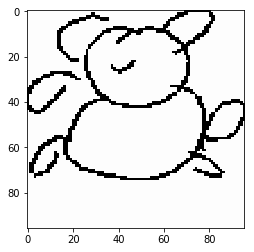

In [256]:
im = draw_it_3channel_plusinfo(small_df.drawing.iloc[0])


# im = im[:,:,0]
# im = np.tile(im[:, :, None], [1, 1, 3])

plt.imshow(im)


In [796]:
# def draw_it_augv3(strokes, imsize,  prob=0.1, aug=True):

#     image = Image.new("P", (300,300), color=255)
#     image_draw = ImageDraw.Draw(image)
    
#     # affine translation
#     offset_x = np.random.randint(5,(300-256)//2-5)
#     offset_y = np.random.randint(5,(300-256)//2-5)
    
#     # affine rotation
#     rotation_val =  math.radians(np.random.uniform(-10,10))
#     strokes = ast.literal_eval(strokes)
    
#     for stroke_order,stroke in enumerate(strokes):
        
#         # adding local jitter per stroke
#         local_offset_x = np.random.randint(-2,2)
#         local_offset_y = np.random.randint(-2,2)
#         local_rotation =  math.radians(np.random.uniform(-2,2))
        
        
#         for i in range(len(stroke[0])-1):
#             x1 = stroke[0][i]+offset_x+local_offset_x
#             y1 = stroke[1][i]+offset_y+local_offset_y
#             x2 = stroke[0][i+1]+offset_x+local_offset_x
#             y2 = stroke[1][i+1]+offset_y+local_offset_y
            
#             x1, y1 = rotate_point((150,150),(x1,y1),rotation_val+local_rotation)
#             x2, y2 = rotate_point((150,150),(x2,y2),rotation_val+local_rotation)
#             image_draw.line([x1, 
#                              y1,
#                              x2, 
#                              y2],
#                             fill=0, width=5)
            
#     image = image.resize(( imsize,  imsize))
#     image = np.array(image)/255.
    
#     if np.random.rand() < 0.5:
#         image = np.flip(image,axis=1)
    
# #     plt.imshow(image)
    
#     return np.reshape(image,image.shape+(1,))


# def get_augmented_strokes(strokes, prob=0.1):
#     augmented = []
#     strokes = ast.literal_eval(strokes)
    
#     for i,stroke in enumerate(strokes):
        
#         stroke_drop_prob = prob*((i+1)/len(strokes))
#         # drop final strokes with a higher chance 
#         if np.random.rand() < stroke_drop_prob:
#             print("dropping stroke")
#             continue
            
#         if len(stroke[0]) < 3 : 
#             augmented.append(stroke)
#             continue
#         else:
#             new_stroke =[[],[]]
#             for i in range(0,len(stroke[0])):
#                 if i > 0 and i < len(stroke[0])-1:
#                     if np.random.rand() < prob:
# #                         print("skipping adding item")
#                         continue 
# #                     if np.random.rand() < prob:
# # #                         print("adjusting stroke by a random number")
# #                         delta_x = np.random.randint(-5,5)
# #                         delta_y = np.random.randint(-5,5)
# #                         stroke[0][i] += delta_x
# #                         stroke[1][i] += delta_y
                        
#                 new_stroke[0].append(stroke[0][i])
#                 new_stroke[1].append(stroke[1][i])
            
#             augmented.append(new_stroke)
#     return str(augmented)

In [16]:

def draw_it( strokes,imsize):

    image = Image.new("P", (300,300), color=255)
    image_draw = ImageDraw.Draw(image)

    offset = (300-256)//2

    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i]+offset, 
                             stroke[1][i]+offset,
                             stroke[0][i+1]+offset, 
                             stroke[1][i+1]+offset],
                            fill=0, width=5)

    image = image.resize(( imsize,  imsize))
    image = np.array(image)/255.
    plt.imshow(image)

    return np.reshape(image,image.shape+(1,))


In [860]:
# def draw_it(strokes, imsize):

#     image = Image.new("P", (300,300), color=255)
#     offset = (300-256)//2
#     image_draw = ImageDraw.Draw(image)
#     for stroke in ast.literal_eval(strokes):
#         for i in range(len(stroke[0])-1):
#             image_draw.line([stroke[0][i]+offset, 
#                              stroke[1][i]+offset,
#                              stroke[0][i+1]+offset, 
#                              stroke[1][i+1]+offset],
#                             fill=0, width=5)
            
#     image = image.resize(( imsize,  imsize))
#     image = np.array(image)/255.
    
#     plt.imshow(image)
    
#     return np.reshape(image,image.shape+(1,))

In [76]:
strokes = small_df.drawing.iloc[29]


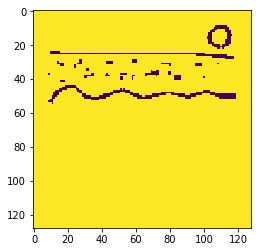

In [77]:
img = draw_it(strokes, 128)


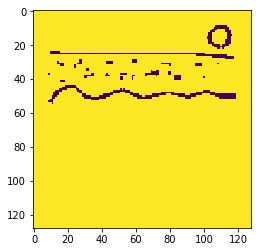

In [90]:
img = draw_it_augv3(strokes, 128)

In [865]:
# strokes_new = get_augmented_strokes(strokes,0.1)
# new_img = draw_it(strokes_new, 256)

In [40]:
from imgaug import augmenters as iaa
import imgaug as ia

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
# seq = iaa.Sequential([
#     iaa.Fliplr(0.2), # horizontally flip 50% of the images
#     iaa.Flipud(0.2)# horizontally flip 50% of the images    
# #     sometimes(iaa.Affine(
# # #         translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # translate by -10 to +10 percent (per axis)
# # #         rotate=(-2, 2), # rotate by -45 to +45 degrees
# # #         shear=(-20, 20), # shear by -16 to +16 degrees
# #         cval=1
# #     ))   
#     ])

# seq = iaa.Sequential([
#     iaa.Fliplr(0.5),
# #     iaa.Flipud(0.2),
# #     sometimes(iaa.Affine(scale={"y": (0.8, 1.2)} ,  cval=1)),
#     sometimes(iaa.Affine(translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},cval=1)),
# #     sometimes(iaa.Affine(shear=(-5, 5),  cval=1)),
#     sometimes(iaa.Affine(rotate=(-10, 10),  cval=1))
#     ])		

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
#         iaa.Flipud(0.2), # vertically flip 20% of all images
#         # crop images by -5% to 10% of their height/width
#         sometimes(iaa.CropAndPad(
#             percent=(-0.05, 0.1),
#             pad_mode=ia.ALL,
#             pad_cval=1
#         )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=1, # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))])

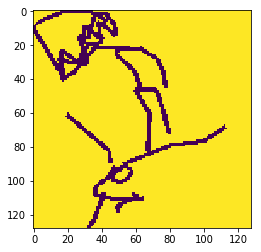

In [53]:
images_aug = seq.augment_images(new_img.reshape(1,128,128,1))
plt.imshow(images_aug.reshape(128,128))